### Sequence task
쌀 이파리 병에 대한 분류

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 이미지 데이터 세트 경로 지정
root = './datasets/rice_leaf_diseases_dataset/original/'

# 이미지 전처리 객체 선언
idg = ImageDataGenerator()
# 경로를 통해 이미지 불러온 후 이미지 전처리 진행
# target_size: 이미지 크기 지정, batch_size: 배치 크기, class_mode: 원-핫 인코딩된 클래스 레이블
generator = idg.flow_from_directory(root, target_size=(64, 64), batch_size=20, class_mode='categorical')

# 각 클랙스의 이름과 인덱스 출력
print(generator.class_indices)
# 각 이미지 파일이 속한 인덱스 값 출력
print(generator.classes)

Found 4684 images belonging to 3 classes.
{'Bacterialblight': 0, 'Brownspot': 1, 'Leafsmut': 2}
[0 0 0 ... 2 2 2]


In [2]:
# 각 타겟의 타겟 이름을 담기 위해 key와 value의 순서 변경하여 타겟의 고유값을 저장
target_name = {v: k for k, v in generator.class_indices.items()}
target_name

{0: 'Bacterialblight', 1: 'Brownspot', 2: 'Leafsmut'}

In [3]:
# 각 타겟의 이름 담을 초기 list 선언
target_names = []
# 각 타겟의 인덱스를 확인하여 인덱스에 맞는 타겟 이름을 담아주기
for target in generator.classes:
    target_names.append(target_name[target])

In [4]:
import pandas as pd

# 파일 경로와 타겟값을 가지고 새로운 데이터 프레임 생성
rice_df = pd.DataFrame({'file_paths': generator.filepaths, 'target_names': target_names, 'targets': generator.classes})
# 경로 중 \\(역슬래시)로 되어 있는 부분을 /(슬래시)로 변경
rice_df.file_paths = rice_df.file_paths.apply(lambda file_path: file_path.replace('\\', '/'))
rice_df

,file_paths,target_names,targets
0,./datasets/rice_leaf_diseases_dataset/original...,Bacterialblight,0
1,./datasets/rice_leaf_diseases_dataset/original...,Bacterialblight,0
2,./datasets/rice_leaf_diseases_dataset/original...,Bacterialblight,0
3,./datasets/rice_leaf_diseases_dataset/original...,Bacterialblight,0
4,./datasets/rice_leaf_diseases_dataset/original...,Bacterialblight,0
...,...,...,...
4679,./datasets/rice_leaf_diseases_dataset/original...,Leafsmut,2
4680,./datasets/rice_leaf_diseases_dataset/original...,Leafsmut,2
4681,./datasets/rice_leaf_diseases_dataset/original...,Leafsmut,2
4682,./datasets/rice_leaf_diseases_dataset/original...,Leafsmut,2


In [5]:
from sklearn.model_selection import train_test_split

# 데이터 세트 분리
train_images, test_images, train_targets, test_targets = train_test_split(rice_df.file_paths, rice_df.targets, stratify=rice_df.targets, test_size=0.2, random_state=124)
# 검증용 데이터 세트 분리
train_images, validation_images, train_targets, validation_targets = train_test_split(train_images, train_targets, stratify=train_targets, test_size=0.2, random_state=124)

# 타겟 비중 확인
print(train_targets.value_counts())
print(validation_targets.value_counts())
print(test_targets.value_counts())

targets
1    1037
0    1026
2     934
Name: count, dtype: int64
targets
1    259
0    257
2    234
Name: count, dtype: int64
targets
1    324
0    321
2    292
Name: count, dtype: int64


In [6]:
# 인덱스 번호를 대조하여 각 데이터 프레임 나누기
train_df = rice_df.iloc[train_images.index].reset_index(drop=True)
validation_df = rice_df.iloc[validation_images.index].reset_index(drop=True)
test_df = rice_df.iloc[test_images.index].reset_index(drop=True)

print(train_df.shape)
print(validation_df.shape)
print(test_df.shape)

(2997, 3)
(750, 3)
(937, 3)


In [7]:
import numpy as np
from tensorflow.keras.utils import Sequence
from sklearn.utils import shuffle
import cv2

# 이미지 사이즈 및 배치 사이즈
IMAGE_SIZE = 64
BATCH_SIZE = 64

# 데이터 세트 생성 class 정의
class Dataset(Sequence):
    # 클래스의 초기화
    # 경로, 타겟, 배치 크기, albumentations 객체, 전처리 하마, 셔플 여부를 인자로 받음
    def __init__(self, file_paths, targets, batch_size=BATCH_SIZE, aug=None, preprocess=None, shuffle=False):
        self.file_paths = file_paths
        self.targets = targets
        self.batch_size = batch_size
        self.aug = aug
        self.preprocess = preprocess
        self.shuffle = shuffle

        # shuffle True 시 진행:
        if self.shuffle:
            # epoch 끝날 때마다 호출
            self.on_epoch_end()

    # 전체 데이터 세트 크기 반환
    def __len__(self):
        # 하나의 배치 사이즈에 필요한 데이터 개수 리턴
        return int(np.ceil(len(self.targets) / self.batch_size))

    # 주어진 인덱스에 해당하는 배치 반환
    def __getitem__(self, index):
        # 파일 경로와 타겟 데이터를 배치 크기만큼 자르고, 이미지를 불러와 처리한 후 배치로 반환
        file_paths_batch = self.file_paths[index * self.batch_size: (index + 1) * self.batch_size]
        targets_batch = self.targets[index * self.batch_size: (index + 1) * self.batch_size]

        # 데이터 배치 저장
        results_batch = np.zeros((file_paths_batch.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))

        # 데이터 수만큼 반복
        for i in range(file_paths_batch.shape[0]):
            # RGB로 색상 형식을 변환하여 이미지 가져오기
            image = cv2.cvtColor(cv2.imread(file_paths_batch[i]), cv2.COLOR_BGR2RGB)
            # 이미지 크기 조정
            image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))

            # albumentations이 있다면:
            if self.aug is not None:
                # Augmentor 객체로 이미지 변환
                image = self.aug(image=image)['image']

            # 전처리 함수가 있다면:
            if self.preprocess is not None:
                # 이미지 전처리 진행
                image = self.preprocess(image)

            # 결과 배치에 이미지를 저장
            results_batch[i] = image

        # 결과 배치와 타겟 배치를 반환
        return results_batch, targets_batch
        
    def on_epoch_end(self):
        # shuffle 옵션이 켜져있다면, 데이터를 섞기
        if self.shuffle:
            # epoch 끝날 때마다 데이터 섞기
            self.file_paths, self.targets = shuffle(self.file_paths, self.targets)        

In [8]:
import albumentations as A
# preprocess_input 함수에 별칭 지정
# tensorflow와 torch 모두 같은 이름의 함수를 받기 때문에 별칭으로 구분
from tensorflow.keras.applications.xception import preprocess_input as xception_preprocess_input

# 데이터 경로 담기
train_file_paths = train_df['file_paths'].values
# 데이터 타겟 담기
# get_dummies를 통해 원-핫 인코딩 진행
train_targets = pd.get_dummies(train_df['targets']).values # CategoricalCrossEntropy

# 데이터 경로 담기
validation_file_paths = validation_df['file_paths'].values
# 데이터 타겟 담기
# get_dummies를 통해 원-핫 인코딩 진행
validation_targets = pd.get_dummies(validation_df['targets']).values # CategoricalCrossEntropy

# 데이터 경로 담기
test_file_paths = test_df['file_paths'].values
# 데이터 타겟 담기
# get_dummies를 통해 원-핫 인코딩 진행
test_targets = pd.get_dummies(test_df['targets']).values # CategoricalCrossEntropy

# 이미지 변환 (증강)
aug = A.Compose([
    # 크기 조정 및 회전
    A.ShiftScaleRotate(p=0.5),
    # 좌우 반전
    A.HorizontalFlip(p=0.5),
    # 밝기 및 대비 변경
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0, p=0.5)
])

# Dataset class로 객체 생성
train_dataset = Dataset(train_file_paths, 
                        train_targets, 
                        batch_size=BATCH_SIZE, 
                        aug=aug, 
                        preprocess=xception_preprocess_input, 
                        shuffle=True)

validation_dataset = Dataset(validation_file_paths, 
                        validation_targets, 
                        batch_size=BATCH_SIZE, 
                        preprocess=xception_preprocess_input)

test_dataset = Dataset(test_file_paths, 
                        test_targets, 
                        batch_size=BATCH_SIZE, 
                        preprocess=xception_preprocess_input)

In [9]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense , Conv2D , Dropout , Flatten , Activation, MaxPooling2D , GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import MobileNetV2 # 작은 장치에서도 성능을 끌어올릴 수 있는 모델

# 모델 생성 함수 선언
# model_name: 사전 훈련 모델 이름, verbose: 모델 요약 출력 여부
def create_model(model_name='vgg16', verbose=False):
    # Input layer: 이미지 크기와 채널 수를 지정
    input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    # VGG16 모델 선택
    if model_name == 'vgg16':
        model = VGG16(input_tensor=input_tensor, include_top=False, weights='imagenet')
    # ResNet50V2 모델 선택
    elif model_name == 'resnet50': # ResNet50, 74.9% ; ResNet50V2, 76.0%
        model = ResNet50V2(input_tensor=input_tensor, include_top=False, weights='imagenet')
    # Xception 모델 선택
    elif model_name == 'xception': # Inception을 기초로 한 모델
        model = Xception(input_tensor=input_tensor, include_top=False, weights='imagenet')
    # MobileNetV2 모델 선택
    elif model_name == 'mobilenet':
        model = MobileNetV2(input_tensor=input_tensor, include_top=False, weights='imagenet')

    # output layer: 모델 출력 층 
    x = model.output

    # 분류기
    # GlobalAveragePooling2D: 글로벌 평균 풀링 층을 추가하여 특성 맵의 공간 차원 축소
    x = GlobalAveragePooling2D()(x)
    # hidden layer: VGG16 모델 선택을 선택하지 않았다면 dropout 미진행
    if model_name != 'vgg16':
        x = Dropout(rate=0.5)(x)

    # hidden layer: 50개의 뉴런과 ReLU 활성화 함수 사용
    x = Dense(50, activation='relu')(x)

    # hidden layer: VGG16 모델 선택을 선택하지 않았다면 dropout 미진행
    if model_name != 'vgg16':
        x = Dropout(rate=0.5)(x)

    # output layer: 10개의 뉴런과 소프트맥스 활성화 함수를 사용하여 클래스 확률 출력
    output = Dense(3, activation='softmax', name='output')(x)

    # 모델 생성: 입력과 출력을 지정하여 모델 정의
    model = Model(inputs=input_tensor, outputs=output)

    # verbose가 True인 경우 모델 요약 출력
    if verbose:
        model.summary()
    
    return model

In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

# weights 저장
mcp_cb = ModelCheckpoint(
    filepath="./callback_files/weights.{epoch:03d}-{val_loss:.4f}-{acc:.4f}.weights.h5",
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    mode='min'
)

# 일정 기간 동안 성능이 개선되지 않을 시 학습률 동적으로 감소
rlr_cb = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=2,
    mode='min'
)

# 일정 기간 동안 성능이 개선되지 않을 시 학습 조기 중단
ely_cb = EarlyStopping(
    monitor='val_loss',
    patience=4,
    mode='min'
)

In [11]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy

# 모델 생성 함수를 사용하여 모델 생성
model = create_model(model_name='vgg16', verbose=True)

# 모델 컴파일: 학습 프로세스 설정
# optimizer: 최적화 알고리즘, loss: 손실함수, metrics: 성능지표
model.compile(optimizer=Adam(), loss=CategoricalCrossentropy(), metrics=['acc'])

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 64, 64, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 64, 64, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 16, 16, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 50)                  │          25,6

 Total params: 14,740,491 (56.23 MB)

 Trainable params: 14,740,491 (56.23 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
import gc

# 메모리 해제 함수
gc.collect()

13

In [13]:
# 반복횟수 지정
# 대문자로 상수를 표기하면 다른 부분에서 변경되지 않는다는 것을 의미
N_EPOCHS = 10

# 훈련
history = model.fit(train_dataset,
                    batch_size=BATCH_SIZE,
                    epochs=N_EPOCHS, 
                    validation_data=validation_dataset,
                    callbacks=[rlr_cb, ely_cb])

Epoch 1/10


C:\Users\LEGION\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


47/47 ━━━━━━━━━━━━━━━━━━━━ 355s 7s/step - acc: 0.3957 - loss: 6.9114 - val_acc: 0.6107 - val_loss: 0.9292 - learning_rate: 0.0010
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 331s 7s/step - acc: 0.6405 - loss: 0.8266 - val_acc: 0.7413 - val_loss: 0.6763 - learning_rate: 0.0010
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 330s 7s/step - acc: 0.6882 - loss: 0.6800 - val_acc: 0.7067 - val_loss: 0.6833 - learning_rate: 0.0010
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 329s 7s/step - acc: 0.7350 - loss: 0.6306 - val_acc: 0.7533 - val_loss: 0.5702 - learning_rate: 0.0010
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 328s 7s/step - acc: 0.7751 - loss: 0.5366 - val_acc: 0.8107 - val_loss: 0.4905 - learning_rate: 0.0010
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 328s 7s/step - acc: 0.8236 - loss: 0.4845 - val_acc: 0.8293 - val_loss: 0.4472 - learning_rate: 0.0010
Epoch 7/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 329s 7s/step - acc: 0.7625 - loss: 0.5671 - val_acc: 0.8573 - val_loss: 0.4236 - learning_rate: 0.0010
Epoch 8/10
47/47 ━━━━━━━

In [15]:
# 평가
model.evaluate(test_dataset)

15/15 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - acc: 0.9331 - loss: 0.2161


[0.21973110735416412, 0.9327641129493713]

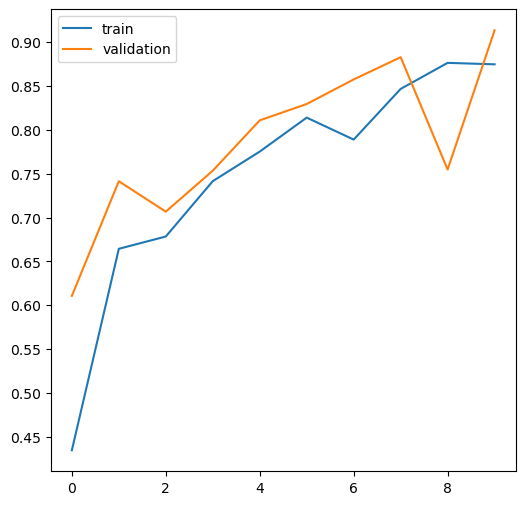

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# 학습과정 지표를 그래프화
def show_history(history):
    plt.figure(figsize=(6, 6))
    plt.yticks(np.arange(0, 1, 0.05))
    plt.plot(history.history['acc'], label='train')
    plt.plot(history.history['val_acc'], label='validation')
    plt.legend()
    
show_history(history)